# Capstone Project - Determination of the appropriate location in the condo investments

# Introduction

At present, there are many condos, especially within the city, which have a lot of facilities. Causing those who are interested in investing in condos that are difficult to decide to find a suitable location. In the aspect of the entrepreneurs themselves, they want to find suitable areas for investment to establish condos to meet the demands of consumers as well.


# Data Description

* Information on the latitude and longitude of a point that is the centroid of each district in Bangkok comes from the **Wikipedia** web site.

* Information about condo candidates uses **Foursquare API** to find the latitude and longitude of the location of each district.

* The venue candidates use **Foursquare API** to find the latitude and longitude of each area, Which will set the boundary within 2000 meters

* Shapefiles each zone from **BangkokGIS** web site

# Data Preprocessing
* [**Get the district data by Web Scraping**](#Web-Scraping)
    - [Create the data frame](#Creat-the-data-frame-from-web-scraping)
    - [Cleaning data](#Cleaning-data)
    - [Visualization of the district (*Map*)](#Create-map-the-district-of-Bangkok)
    
* [**Explore the condo of the district by Foursquare API**](#Explore-the-condo-of-the-district-by-Foursquare-API)
    - [Create a function for Foursquare API](#Create-a-function-to-get-the-condo-of-the-district)
    - [Create the data frame](#Create-dataframe-the-condo-of-the-district)
    - [Cleaning data](#Cleaning-condo-data)
    - [Check the condo in the area by shapefile](#Group-the-condo-of-the-district-by-shapefile)
    - [Top 10 condo in the district](#Top-10-Condo)
    - [Visualization of the condo density (*Map*)](#Visualization-of-the-condo-density)
    
* [**Explore the venue of the district by Foursquare API**](#Explore-the-venue-of-the-district-by-Foursquare-API)
    - [Create a function for Foursquare API](#Create-a-function-to-get-the-neighborhood-venue-of-the-district)
    - [Create the data frame](#Create-dataframe-the-neighborhood-venue-of-the-district-in-2000-meters)
    - [Transform data](#Transform-data-by-dummies)
    - [Analyze the top 10 venues for each neighborhood](#Create-the-new-dataframe-and-display-the-top-10-venues-for-each-neighborhood)
    - [Visualization of the venue distribution (*Map*)](#Visualization-of-the-venue-distribution)

# Machine Learning
* [**Unsupervised Machine Learning**](#Unsupervised-Machine-Learning)
    - [DBSCAN modeling](#Clustering---DBSCAN)
    - [Exploration of the venue](#Exploration-of-the-venue)
    - [Visualizing DBSCAN Clustering](#Visualizing-DBSCAN-Clustering)
    - [Top 5 cluster](#Top-5-cluster)
    - [Visualization of the condo density and the top 5 DBSCAN clustering (*Map*)](#Visualization-of-the-condo-density-and-the-top-5-DBSCAN-clustering)
    - [Explore the venue of the DBSCAN clustering](#Explore-the-venue-of-the-DBSCAN-clustering)
    - [Top 10 venues of the DBSCAN clustering](#Top-10-venues-of-the-DBSCAN-clustering)

# Web Scraping

## Get data from web

In [2]:
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import numpy as np

from bs4 import BeautifulSoup
import requests

# Get link
link = requests.get('https://en.wikipedia.org/wiki/List_of_districts_of_Bangkok').text
soup = BeautifulSoup(link, 'lxml')

In [3]:
# Find wikipedia table
wiki_table = soup.find('table',{'class':'wikitable sortable'})
#wiki_table

In [4]:
# Find Headers in the wiki table
find_headers = wiki_table.find_all('th')
header_cols = [i.text.replace('\n', '') for i in find_headers]
header_cols

['District(Khet)',
 'Code',
 'Thai',
 'Population',
 'No. ofSubdistricts(Khwaeng)',
 'Latitude',
 'Longitude']

In [5]:
# Find Values in the wiki table
find_values = wiki_table.find_all('td')
values_cols = [i.text.replace('\n', '') for i in find_values]
values_cols[0:7]

['Bang Bon', '50', 'บางบอน', '105,161', '4', 'NA', 'NA']

## Creat the data frame from web scraping

In [6]:
# Create DataFrame
dist_Bangkok = pd.DataFrame(columns=header_cols, data=np.reshape(values_cols,(-1,7)))
dist_Bangkok.columns = ['District(EN)',
                        'Code',
                        'District(TH)',
                        'Population',
                        'Number of SubDist',
                        'Latitude',
                        'Longitude']

# Handle columns
move_cols = [dist_Bangkok.columns[0]] + [dist_Bangkok.columns[2]] + [dist_Bangkok.columns[1]] + list(dist_Bangkok.columns[3:])
dist_Bangkok = dist_Bangkok[move_cols]

print('Number of District of Bangkok : {}'.format(dist_Bangkok.shape[0]))
dist_Bangkok.head()

Number of District of Bangkok : 50


,District(EN),District(TH),Code,Population,Number of SubDist,Latitude,Longitude
0,Bang Bon,บางบอน,50,"105,161",4,NA,NA
1,Bang Kapi,บางกะปิ,06,"148,465",2,13.765833,100.647778
2,Bang Khae,บางแค,40,"191,781",4,13.696111,100.409444
3,Bang Khen,บางเขน,05,"189,539",2,13.873889,100.596389
4,Bang Kho Laem,บางคอแหลม,31,"94,956",3,13.693333,100.5025


## Cleaning data

Each latitude-longitude to represent the centroid point of each district to find all the information in 45 districts out of 50 districts, because some districts don't have latitude-longitude information.

In [7]:
# Replace 'NA' to NaN values
dist_Bangkok = dist_Bangkok.replace('NA', np.NAN)
dist_Bangkok = dist_Bangkok.dropna()

dist_Bangkok = dist_Bangkok.reset_index(drop=True)

print('Number of District of Bangkok : {}'.format(dist_Bangkok.shape[0]))
dist_Bangkok.head()

Number of District of Bangkok : 45


,District(EN),District(TH),Code,Population,Number of SubDist,Latitude,Longitude
0,Bang Kapi,บางกะปิ,06,"148,465",2,13.765833,100.647778
1,Bang Khae,บางแค,40,"191,781",4,13.696111,100.409444
2,Bang Khen,บางเขน,05,"189,539",2,13.873889,100.596389
3,Bang Kho Laem,บางคอแหลม,31,"94,956",3,13.693333,100.5025
4,Bang Khun Thian,บางขุนเทียน,21,"165,491",2,13.660833,100.435833


[View full dataset](https://github.com/Supanut-k/The_Neighborhood_Of_The_Condo/blob/master/Data/District%20of%20Bangkok.csv)

## Covert data type of columns

In [8]:
dist_Bangkok[list(dist_Bangkok.columns[5:7])] = dist_Bangkok[list(dist_Bangkok.columns[5:7])].astype(float)
dist_Bangkok['Population'] = dist_Bangkok['Population'].str.replace(',','')
dist_Bangkok[['Population','Number of SubDist']] = dist_Bangkok[['Population','Number of SubDist']].astype(int)
dist_Bangkok.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45 entries, 0 to 44
Data columns (total 7 columns):
District(EN)         45 non-null object
District(TH)         45 non-null object
Code                 45 non-null object
Population           45 non-null int32
Number of SubDist    45 non-null int32
Latitude             45 non-null float64
Longitude            45 non-null float64
dtypes: float64(2), int32(2), object(3)
memory usage: 2.2+ KB


## Create map the district of Bangkok

In [11]:
# Convert an address into latitude and longitude values
from geopy.geocoders import Nominatim

# Create map
import folium

In [15]:
address = 'Bangkok, Thailand'
geolocator = Nominatim(user_agent="th_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Bangkok are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Bangkok are 13.7538929, 100.8160803.


In [18]:
# Create map of Bangkok using Latitude and Longitude values
map_bk = folium.Map(location=[latitude, longitude], zoom_start=9.4)

# Add markers to map
for lat, lng, dist in zip(dist_Bangkok['Latitude'],
                          dist_Bangkok['Longitude'],
                          dist_Bangkok['District(EN)']):
    
    label = dist
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker([lat, lng],
                         radius=5,
                         popup=label,
                         color='blue',
                         fill=True,
                         fill_color='#54aee5',
                         fill_opacity=0.7,
                         parse_html=False).add_to(map_bk) 
map_bk


![title](https://github.com/Supanut-k/The_Neighborhood_Of_The_Condo/blob/master/Maps/Map%20Images/map_district_bkk.png?raw=true)

Interactive map [Click here](https://github.com/Supanut-k/The_Neighborhood_Of_The_Condo/blob/master/Maps/map_district_bkk.html)

----

# Explore the condo of the district by Foursquare API

After receiving each latitude-longitude point, enter the data through the Foursquare API to find the Condo in each area.

## Create an account to access Foursquare API

In [19]:
CLIENT_ID = 'XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX' # your Foursquare ID
CLIENT_SECRET = 'XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

#print('Your credentails:')
#print('CLIENT_ID: ' + CLIENT_ID)
#print('CLIENT_SECRET:' + CLIENT_SECRET)

## Create a function to get the condo of the district

In [21]:
def findNearbyVenues(dist, lat, lng, query='condo'):         
    
    venues_list=[]
    for dists, lat, lng in zip(dist, lat, lng):
        url = 'https://api.foursquare.com/v2/venues/search?&client_id={}&client_secret={}&v={}&ll={},{}&query={}'.format(
                    CLIENT_ID, 
                    CLIENT_SECRET, 
                    VERSION, 
                    lat, 
                    lng,
                    query)

        results = requests.get(url).json()['response']['venues']
        
        venues_list.append([(
            dists, 
            lat, 
            lng, 
            v['name'],
            v['categories'],
            v['location']['lat'], 
            v['location']['lng'],           
            v['id']) for v in results])
        
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['District', 
                  'Latitude', 
                  'Longitude', 
                  'Venue',
                  'Venue Category',                             
                  'Venue Latitude', 
                  'Venue Longitude',                 
                  'Venue id']
    
    return(nearby_venues)

## Create dataframe the condo of the district

In [22]:
condo_dists = findNearbyVenues(dist=dist_Bangkok['District(EN)'],
                               lat=dist_Bangkok['Latitude'],
                               lng=dist_Bangkok['Longitude'])

In [23]:
print(condo_dists.shape)
condo_dists.head()

(1350, 8)


,District,Latitude,Longitude,Venue,Venue Category,Venue Latitude,Venue Longitude,Venue id
0,Bang Kapi,13.765833,100.647778,BANGKAPI CONDO TOWN,"[{'id': '4bf58dd8d48988d130941735', 'name': 'B...",13.771145,100.644855,4d7fa56d4219a1cd659f78d3
1,Bang Kapi,13.765833,100.647778,Plum Condo Paholyothin 89 (พลัมคอนโด พหลโยธิน 89),"[{'id': '4d954b06a243a5684965b473', 'name': 'R...",13.970139,100.617078,55c94c09498e803389db14f2
2,Bang Kapi,13.765833,100.647778,My Condo f.9,"[{'id': '4bf58dd8d48988d1f3941735', 'name': 'T...",13.765682,100.647555,4dc17dd2e4cda3b87f22f6bd
3,Bang Kapi,13.765833,100.647778,ABAC Condo (อาคารเอแบคคอนโดทาวน์),"[{'id': '4d954b06a243a5684965b473', 'name': 'R...",13.752997,100.628598,4c04f7229a7920a122e5d179
4,Bang Kapi,13.765833,100.647778,Livingnest Condo,"[{'id': '4d954b06a243a5684965b473', 'name': 'R...",13.763514,100.640571,55fd3c8b498ed76a0d7488e4


## Cleaning condo data

In [24]:
# Extract value categoies of 'Venue Category' column
values_types = []
for i in range(len(condo_dists['Venue Category'])):
    if len(condo_dists['Venue Category'][i]) == 0 :
        values_types.append(None)
    else:
        values_types.append(condo_dists['Venue Category'][i][0]['name'])
        
condo_dists['Venue Category'] = pd.Series(values_types)
print(condo_dists.shape)
condo_dists.head()

(1350, 8)


,District,Latitude,Longitude,Venue,Venue Category,Venue Latitude,Venue Longitude,Venue id
0,Bang Kapi,13.765833,100.647778,BANGKAPI CONDO TOWN,Building,13.771145,100.644855,4d7fa56d4219a1cd659f78d3
1,Bang Kapi,13.765833,100.647778,Plum Condo Paholyothin 89 (พลัมคอนโด พหลโยธิน 89),Residential Building (Apartment / Condo),13.970139,100.617078,55c94c09498e803389db14f2
2,Bang Kapi,13.765833,100.647778,My Condo f.9,Toy / Game Store,13.765682,100.647555,4dc17dd2e4cda3b87f22f6bd
3,Bang Kapi,13.765833,100.647778,ABAC Condo (อาคารเอแบคคอนโดทาวน์),Residential Building (Apartment / Condo),13.752997,100.628598,4c04f7229a7920a122e5d179
4,Bang Kapi,13.765833,100.647778,Livingnest Condo,Residential Building (Apartment / Condo),13.763514,100.640571,55fd3c8b498ed76a0d7488e4


## Group the condo of the district by shapefile

In [28]:
import geopandas as gpd

# import .shp
geo_dist = gpd.read_file('district.shp')

# convert coodinate
geo_dist = geo_dist.to_crs(epsg=4326)

# rename column
geo_dist.rename(columns={'dname_e':'District'}, inplace=True)

print(geo_dist.shape)
geo_dist.head()

(50, 3)


,AREA,District,geometry
0,11804564.0,Bang Phlat,"POLYGON ((100.5164934921024 13.80033464327984,..."
1,16319268.0,Huai Khwang,"POLYGON ((100.5885336143809 13.80282060317478,..."
2,17075578.0,Wang Thong Lang,"POLYGON ((100.6129546857929 13.7949467449647, ..."
3,51732144.0,Thawi Watthana,"POLYGON ((100.3967250250955 13.80186943851136,..."
4,128628048.0,Lat Krabang,"POLYGON ((100.7951375255964 13.79398890527035,..."


## Visualize the condo points and the district polygons

Check each condo in the district by using Intersect method between points and polygons.
It can eliminate outliers
 - Points are a latitude-longitude of each condo
 - Polygons are a shapefile of each district 

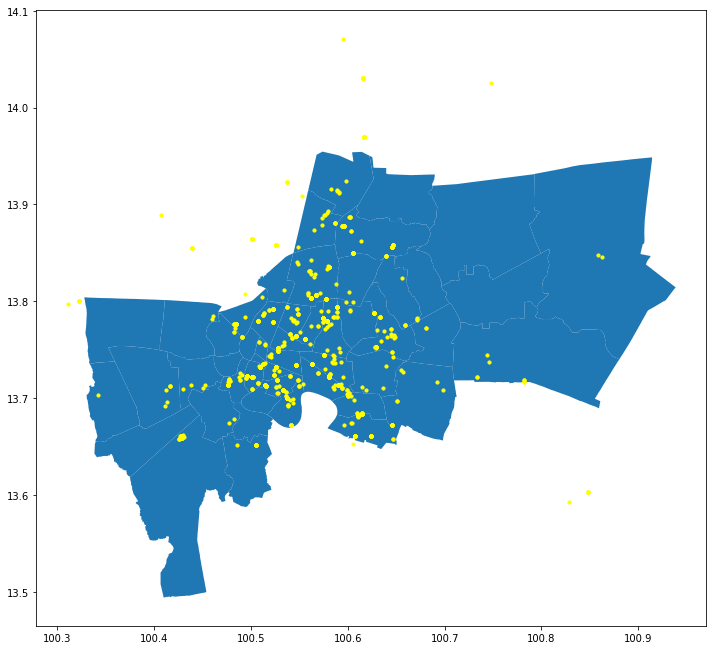

In [30]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(12,12))
geo_dist.plot(ax = ax)
geo_dist = gpd.read_file('district.shp')
geo_dist = geo_dist.to_crs(epsg=4326)
#colors = np.random.rand(3)
condo_dists.plot(kind='scatter',s=10, y='Venue Latitude', x='Venue Longitude',ax=ax, c='Yellow')
ax.set_xlabel('')
ax.set_ylabel('');

## Convert the condo dataframe to geometry format 

In [32]:
from shapely.geometry import Point 

# Convert lat, long of the condominiums to geometry format
condo_points = condo_dists.apply(lambda x : Point([x['Venue Longitude'], x['Venue Latitude']]), axis=1)
geo_condo = gpd.GeoDataFrame(condo_dists, geometry=condo_points)

# Set coordinate
geo_condo.crs = {'init' :'epsg:4326'}

# Got the points of the condominiums
print(geo_condo.shape)
geo_condo.head()

(1350, 9)


,District,Latitude,Longitude,Venue,Venue Category,Venue Latitude,Venue Longitude,Venue id,geometry
0,Bang Kapi,13.765833,100.647778,BANGKAPI CONDO TOWN,Building,13.771145,100.644855,4d7fa56d4219a1cd659f78d3,POINT (100.6448547523296 13.7711450020597)
1,Bang Kapi,13.765833,100.647778,Plum Condo Paholyothin 89 (พลัมคอนโด พหลโยธิน 89),Residential Building (Apartment / Condo),13.970139,100.617078,55c94c09498e803389db14f2,POINT (100.6170777603847 13.97013873672123)
2,Bang Kapi,13.765833,100.647778,My Condo f.9,Toy / Game Store,13.765682,100.647555,4dc17dd2e4cda3b87f22f6bd,POINT (100.647555 13.765682)
3,Bang Kapi,13.765833,100.647778,ABAC Condo (อาคารเอแบคคอนโดทาวน์),Residential Building (Apartment / Condo),13.752997,100.628598,4c04f7229a7920a122e5d179,POINT (100.6285978714163 13.7529965535635)
4,Bang Kapi,13.765833,100.647778,Livingnest Condo,Residential Building (Apartment / Condo),13.763514,100.640571,55fd3c8b498ed76a0d7488e4,POINT (100.6405712461763 13.76351393268389)


## Intersect points between polygons

There are a number of outlier outside of Bangkok city, so use the Intersect method between points and polygons, this method can eliminate a lot of outliers

In [33]:
condos_and_dists = gpd.sjoin(geo_condo, geo_dist, op='within')
condos_and_dists.reset_index(drop=True, inplace=True)

condos_and_dists.drop(['District', 'Latitude', 'Longitude', 'Venue id', 'index_right', 'AREA'], axis=1, inplace=True)

move_cols = [condos_and_dists.columns[-1]] + list(condos_and_dists.columns[0:4]) + [condos_and_dists.columns[-2]]
condos_and_dists = condos_and_dists[move_cols]

condos_and_dists.rename(columns={'dname_e':'District'}, inplace=True)

print(condos_and_dists.shape)
condos_and_dists.head()

C:\Users\User\Anaconda3\lib\site-packages\geopandas\tools\sjoin.py:44: UserWarning: CRS of frames being joined does not match!
  warn('CRS of frames being joined does not match!')


(1217, 6)


,District,Venue,Venue Category,Venue Latitude,Venue Longitude,geometry
0,Bang Kapi,BANGKAPI CONDO TOWN,Building,13.771145,100.644855,POINT (100.6448547523296 13.7711450020597)
1,Bang Kapi,My Condo f.9,Toy / Game Store,13.765682,100.647555,POINT (100.647555 13.765682)
2,Bang Kapi,ABAC Condo (อาคารเอแบคคอนโดทาวน์),Residential Building (Apartment / Condo),13.752997,100.628598,POINT (100.6285978714163 13.7529965535635)
3,Bang Kapi,Livingnest Condo,Residential Building (Apartment / Condo),13.763514,100.640571,POINT (100.6405712461763 13.76351393268389)
4,Bang Kapi,Nirun City Condo (นิรันดร์ซิตี้คอนโด),Residential Building (Apartment / Condo),13.783717,100.633257,POINT (100.6332568565485 13.78371654071318)


In [34]:
# Check Nan values
condos_and_dists.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 1217 entries, 0 to 1216
Data columns (total 6 columns):
District           1217 non-null object
Venue              1217 non-null object
Venue Category     1200 non-null object
Venue Latitude     1217 non-null float64
Venue Longitude    1217 non-null float64
geometry           1217 non-null object
dtypes: float64(2), object(4)
memory usage: 57.1+ KB


In [35]:
# cleaning Nan values
condos_and_dists = condos_and_dists[~condos_and_dists['Venue Category'].isnull()]
print(condos_and_dists.shape)
condos_and_dists.head()

(1200, 6)


,District,Venue,Venue Category,Venue Latitude,Venue Longitude,geometry
0,Bang Kapi,BANGKAPI CONDO TOWN,Building,13.771145,100.644855,POINT (100.6448547523296 13.7711450020597)
1,Bang Kapi,My Condo f.9,Toy / Game Store,13.765682,100.647555,POINT (100.647555 13.765682)
2,Bang Kapi,ABAC Condo (อาคารเอแบคคอนโดทาวน์),Residential Building (Apartment / Condo),13.752997,100.628598,POINT (100.6285978714163 13.7529965535635)
3,Bang Kapi,Livingnest Condo,Residential Building (Apartment / Condo),13.763514,100.640571,POINT (100.6405712461763 13.76351393268389)
4,Bang Kapi,Nirun City Condo (นิรันดร์ซิตี้คอนโด),Residential Building (Apartment / Condo),13.783717,100.633257,POINT (100.6332568565485 13.78371654071318)


In [36]:
print('There are {} uniques categories.'.format(len(condos_and_dists['Venue Category'].unique())))
condos_and_dists.groupby('Venue Category').size()

There are 26 uniques categories.


Venue Category
Art Gallery                                    1
Asian Restaurant                               8
Athletics & Sports                             1
Building                                      56
College Gym                                    2
College Residence Hall                         1
Convenience Store                              2
Coworking Space                                1
Dance Studio                                   1
Gym                                           22
Gym / Fitness Center                          14
Gym Pool                                       2
Nightclub                                      2
Other Great Outdoors                           1
Park                                           1
Parking                                        2
Playground                                     4
Pool                                          12
Residential Building (Apartment / Condo)    1050
Soccer Field                                   2
Sport

In [37]:
# Find Condominium
# Filter Venue Category == Building or Residential Building (Apartment / Condo)
condos_and_dists = condos_and_dists.loc[(condos_and_dists['Venue Category'].str.contains('Condo')) | (condos_and_dists['Venue Category'].str.contains('Building')),:]
condos_and_dists.reset_index(drop=True, inplace=True)

# Replace 'Building' to 'Residential Building (Apartment / Condo)'
condos_and_dists['Venue Category'] = [i.replace('Building', 'Residential Building (Apartment / Condo)') if i == 'Building' else i for i in condos_and_dists['Venue Category']]
print(condos_and_dists.shape)
condos_and_dists.head()

(1106, 6)


,District,Venue,Venue Category,Venue Latitude,Venue Longitude,geometry
0,Bang Kapi,BANGKAPI CONDO TOWN,Residential Building (Apartment / Condo),13.771145,100.644855,POINT (100.6448547523296 13.7711450020597)
1,Bang Kapi,ABAC Condo (อาคารเอแบคคอนโดทาวน์),Residential Building (Apartment / Condo),13.752997,100.628598,POINT (100.6285978714163 13.7529965535635)
2,Bang Kapi,Livingnest Condo,Residential Building (Apartment / Condo),13.763514,100.640571,POINT (100.6405712461763 13.76351393268389)
3,Bang Kapi,Nirun City Condo (นิรันดร์ซิตี้คอนโด),Residential Building (Apartment / Condo),13.783717,100.633257,POINT (100.6332568565485 13.78371654071318)
4,Bang Kapi,Baan Sukhothai Condo,Residential Building (Apartment / Condo),13.758578,100.634192,POINT (100.6341917463778 13.7585780680686)


[View full dataset](https://github.com/Supanut-k/The_Neighborhood_Of_The_Condo/blob/master/Data/Condo%20of%20each%20district.csv)

## Top 10 Condo

In [46]:
sorted_groups = condos_and_dists.groupby(['District']).agg({'Venue Category':'count'}).sort_values(['Venue Category'], ascending=False).reset_index()
sorted_groups.head(10)

,District,Venue Category
0,Khlong Toei,136
1,Khlong San,121
2,Huai Khwang,96
3,Bang Na,89
4,Chatu Chak,73
5,Dusit,66
6,Yan na wa,62
7,Vadhana,57
8,Bang Khen,52
9,Sathon,51


## Visualization of the condo density

In [47]:
import geopandas as gpd
geojson_district = gpd.read_file('district.shp')[['dname_e', 'geometry']]
geojson_district.rename(columns={'dname_e':'District'}, inplace=True)

geojson_district = geojson_district.merge(sorted_groups, on='District' )

print(geojson_district.shape)
print(type(geojson_district))
geojson_district.head()

(39, 3)
<class 'geopandas.geodataframe.GeoDataFrame'>


,District,geometry,Venue Category
0,Bang Phlat,"POLYGON ((663924.7937945767 1526162.056938286,...",29
1,Huai Khwang,"POLYGON ((671711.8643430001 1526487.43818799, ...",96
2,Wang Thong Lang,"POLYGON ((674358.11780704 1525633.939320863, 6...",13
3,Lat Krabang,"POLYGON ((694058.0761932073 1525667.705673218,...",7
4,Din Daeng,"POLYGON ((670239.5504151761 1526284.561835967,...",24


In [48]:
geo_routes = gpd.read_file('routes.shp', encoding = 'utf-8')
geo_routes.head()

,Name,geometry
0,Airport Rail Link Line ดอนเมือง-บางซื่อ-พญาไท-...,"LINESTRING Z (100.7513186 13.6951244 0, 100.75..."
1,สายสีน้ำเงิน (MRT) บางซื่อ-หัวลำโพง-ท่าพระ-พุท...,"LINESTRING Z (100.32955 13.70437 0, 100.39592 ..."
2,สายสีเขียวเข้ม (BTS สายสีลม),"LINESTRING Z (100.4579329 13.7205594 0, 100.45..."
3,สายสีเขียวอ่อน (BTS สายสุขุมวิท),"LINESTRING Z (100.71465 13.93392 0, 100.70768 ..."
4,สายสีม่วง บางใหญ่-บางซื่อ-ราษฎร์บูรณะ,"LINESTRING Z (100.5188409 13.658894 0, 100.516..."


After the exploration, it can be seen that the number of condos is concentrated in the city center, economic area, or connection points for rail transport

In [50]:
# Create map
map_dens = folium.Map(location=[latitude, longitude], zoom_start=10)

# Create Choropleth
folium.Choropleth(
    geo_data='geo_district.geojson',
    data=geojson_district,
    columns=['District', 'Venue Category'],
    key_on='feature.properties.dname_e',    
    fill_color='YlOrBr',
    fill_opacity=0.8,
    line_opacity=0.2,
    highlight=True,
    nan_fill_color='#8c8c8c',
    nan_fill_opacity=0.1,
    line_weight=0.7,
    name='The Condo of Bangkok (Choropleth)',
    legend_name='Condominium density of the district').add_to(map_dens)

# Create Tooltips
folium.GeoJson(geojson_district[['geometry', 'District', 'Venue Category']],
                         name="The Condo of Bangkok (Area)",
                         style_function=lambda x: {'color':'gray','fillColor':'transparent','weight':1},
                         highlight_function=lambda x: {'weight':2,'fillColor':'gray'},
                         tooltip=folium.features.GeoJsonTooltip(fields=['District','Venue Category'],
                                                        aliases=['State:', 'Density:'], 
                                                        labels=True, 
                                                        sticky=True,
                                                        localize=True)).add_to(map_dens)
# Create routes
folium.GeoJson(geo_routes,
               name='Transportation Networks',
               style_function=lambda x: {'weight':3,'color':'#4659D1','dashArray':'1 0'},
               highlight_function=lambda x: {'weight':5,'color':'yellow', 'dashArray':'1 0'},
               tooltip=folium.features.GeoJsonTooltip(fields=['Name'],
                                                      labels=False)).add_to(map_dens)

folium.LayerControl(autoZIndex=True, collapsed=False).add_to(map_dens)

#map_dens.save('map_dens.html')

map_dens

![title](https://github.com/Supanut-k/The_Neighborhood_Of_The_Condo/blob/master/Maps/Map%20Images/map_dens.png?raw=true)

Interactive map [_Click here_](https://github.com/Supanut-k/The_Neighborhood_Of_The_Condo/blob/master/Maps/map_dens.html)

---

# Explore the venue of the district by Foursquare API

Next step, find the venues in 2000 meters from the centroid area of each district by entering the latitude-longitude through Foursquare API.

## Create a function to get the neighborhood venue of the district

In [20]:
def getNearbyVenues(names, latitudes, longitudes, radius=500, LIMIT=100):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        #print(name)
            
        # Create the API request URL 
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # Get all the neighborhoods of disticts
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # Return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'],
            v['venue']['categories'][0]['name'],
            v['venue']['location']['lat'], 
            v['venue']['location']['lng']) for v in results])
    
    # Create DataFrame
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['District', 
                  'Latitude', 
                  'Longitude', 
                  'Venue',
                  'Venue Category',                             
                  'Venue Latitude', 
                  'Venue Longitude']
    nearby_venues[['Venue Latitude', 'Venue Longitude']] = nearby_venues[['Venue Latitude', 'Venue Longitude']].astype(float)
    
    return(nearby_venues)

## Create dataframe the neighborhood venue of the district in 2000 meters

In [51]:
dist_venues = getNearbyVenues(names=dist_Bangkok['District(EN)'],
                                  latitudes=dist_Bangkok['Latitude'],
                                  longitudes=dist_Bangkok['Longitude'],
                                  radius=2000)
print(dist_venues.shape)                       
dist_venues.head()

(3982, 7)


,District,Latitude,Longitude,Venue,Venue Category,Venue Latitude,Venue Longitude
0,Bang Kapi,13.765833,100.647778,ตลาดนัดแฟลตคลองจั่น,Flea Market,13.770105,100.649124
1,Bang Kapi,13.765833,100.647778,ข้าวแกงปักษ์ใต้ แม่ยาใจ,Thai Restaurant,13.770822,100.648628
2,Bang Kapi,13.765833,100.647778,Farm Design (ฟาร์มดีไซน์),Dessert Shop,13.767466,100.642052
3,Bang Kapi,13.765833,100.647778,ฮั่วเซ่งฮง (和成豐),Chinese Restaurant,13.765880,100.641835
4,Bang Kapi,13.765833,100.647778,ซ้งโภชนา ลูกชิ้นปลาทำเอง,Noodle House,13.761782,100.648010


[View full dataset](https://github.com/Supanut-k/The_Neighborhood_Of_The_Condo/blob/master/Data/Venues%20of%20each%20district.csv)

In [52]:
# handle columns
dist_venues.drop(['Latitude', 'Longitude'], axis=1, inplace=True)

In [53]:
dist_venues['Venue Category'].value_counts()

Thai Restaurant                             362
Noodle House                                332
Coffee Shop                                 302
Convenience Store                           188
Café                                        167
Hotel                                       121
Japanese Restaurant                         110
Chinese Restaurant                          104
Asian Restaurant                             99
Som Tum Restaurant                           85
Dessert Shop                                 84
Bar                                          74
BBQ Joint                                    66
Hotpot Restaurant                            65
Seafood Restaurant                           64
Restaurant                                   63
Ice Cream Shop                               61
Fast Food Restaurant                         61
Shopping Mall                                56
Supermarket                                  53
Steakhouse                              

## Transform data by dummies

In [60]:
dist_dummies = pd.get_dummies(dist_venues['Venue Category'])
dist_dummies['District'] = dist_venues['District']

fixed_columns = [dist_dummies.columns[-1]] + list(dist_dummies.columns[:-1])
dist_dummies = dist_dummies[fixed_columns]

In [61]:
dist_dummies.head()

,District,Airport,Airport Food Court,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Arcade,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Astrologer,Athletics & Sports,Australian Restaurant,Auto Garage,BBQ Joint,Badminton Court,Bakery,Bar,Basketball Court,Bed & Breakfast,Beer Bar,Beer Garden,Big Box Store,Bike Rental / Bike Share,Bistro,Boat or Ferry,Bookstore,Botanical Garden,Boutique,Bowling Alley,Boxing Gym,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Buddhist Temple,Buffet,Burger Joint,Bus Station,Bus Stop,Butcher,Café,Cajun / Creole Restaurant,Camera Store,Canal,Cantonese Restaurant,Casino,Chinese Restaurant,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Convention Center,Cosmetics Shop,Coworking Space,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Donburi Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Exhibit,Factory,Farm,Farmers Market,Fast Food Restaurant,Fish & Chips Shop,Fishing Spot,Flea Market,Floating Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Service,Food Truck,Football Stadium,French Restaurant,Fried Chicken Joint,Furniture / Home Store,Garden Center,Gas Station,Gay Bar,German Restaurant,Gift Shop,Golf Course,Golf Driving Range,Gourmet Shop,Government Building,Greek Restaurant,Grocery Store,Gun Range,Gym,Gym / Fitness Center,Gym Pool,Hainan Restaurant,Halal Restaurant,Harbor / Marina,Hardware Store,Historic Site,History Museum,Home Service,Hookah Bar,Hostel,Hotel,Hotel Bar,Hotel Pool,Hotpot Restaurant,Housing Development,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Intersection,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Kaiseki Restaurant,Karaoke Bar,Korean Restaurant,Library,Lounge,Malay Restaurant,Market,Massage Studio,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Mosque,Motorcycle Shop,Movie Theater,Multiplex,Museum,Music Store,Music Venue,Nail Salon,Neighborhood,Night Market,Nightclub,Noodle House,Optical Shop,Organic Grocery,Other Nightlife,Outdoor Gym,Palace,Paper / Office Supplies Store,Park,Pastry Shop,Pedestrian Plaza,Performing Arts Venue,Pet Café,Pet Store,Pharmacy,Photography Lab,Photography Studio,Pier,Pizza Place,Planetarium,Plaza,Pool,Pub,Ramen Restaurant,Recording Studio,Recreation Center,Rental Car Location,Rental Service,Residential Building (Apartment / Condo),Resort,Restaurant,Road,Rock Club,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Satay Restaurant,Scenic Lookout,Science Museum,Seafood Restaurant,Shabu-Shabu Restaurant,Shoe Store,Shop & Service,Shopping Mall,Shopping Plaza,Shrine,Skating Rink,Snack Place,Soba Restaurant,Soccer Field,Soccer Stadium,Social Club,Som Tum Restaurant,Soup Place,Spa,Speakeasy,Spiritual Center,Sporting Goods Shop,Sports Club,Stables,Stadium,Steakhouse,Street Food Gathering,Supermarket,Sushi Restaurant,Swiss Restaurant,Takoyaki Place,Tea Room,Thai Restaurant,Theater,Theme Park,Theme Park Ride / Attraction,Tonkatsu Restaurant,Tour Provider,Track,Train Station,Vegetarian / Vegan Restaurant,Veterinarian,Vietnamese Restaurant,Warehouse Store,Water Park,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Yoshoku Restaurant,Zoo,Zoo Exhibit
0,Bang Kapi,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [62]:
venues_grouped = dist_dummies.groupby('District').mean().reset_index()
print(venues_grouped.shape)
venues_grouped.head()

(45, 252)


,District,Airport,Airport Food Court,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Arcade,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Astrologer,Athletics & Sports,Australian Restaurant,Auto Garage,BBQ Joint,Badminton Court,Bakery,Bar,Basketball Court,Bed & Breakfast,Beer Bar,Beer Garden,Big Box Store,Bike Rental / Bike Share,Bistro,Boat or Ferry,Bookstore,Botanical Garden,Boutique,Bowling Alley,Boxing Gym,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Buddhist Temple,Buffet,Burger Joint,Bus Station,Bus Stop,Butcher,Café,Cajun / Creole Restaurant,Camera Store,Canal,Cantonese Restaurant,Casino,Chinese Restaurant,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Convention Center,Cosmetics Shop,Coworking Space,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Donburi Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Exhibit,Factory,Farm,Farmers Market,Fast Food Restaurant,Fish & Chips Shop,Fishing Spot,Flea Market,Floating Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Service,Food Truck,Football Stadium,French Restaurant,Fried Chicken Joint,Furniture / Home Store,Garden Center,Gas Station,Gay Bar,German Restaurant,Gift Shop,Golf Course,Golf Driving Range,Gourmet Shop,Government Building,Greek Restaurant,Grocery Store,Gun Range,Gym,Gym / Fitness Center,Gym Pool,Hainan Restaurant,Halal Restaurant,Harbor / Marina,Hardware Store,Historic Site,History Museum,Home Service,Hookah Bar,Hostel,Hotel,Hotel Bar,Hotel Pool,Hotpot Restaurant,Housing Development,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Intersection,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Kaiseki Restaurant,Karaoke Bar,Korean Restaurant,Library,Lounge,Malay Restaurant,Market,Massage Studio,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Mosque,Motorcycle Shop,Movie Theater,Multiplex,Museum,Music Store,Music Venue,Nail Salon,Neighborhood,Night Market,Nightclub,Noodle House,Optical Shop,Organic Grocery,Other Nightlife,Outdoor Gym,Palace,Paper / Office Supplies Store,Park,Pastry Shop,Pedestrian Plaza,Performing Arts Venue,Pet Café,Pet Store,Pharmacy,Photography Lab,Photography Studio,Pier,Pizza Place,Planetarium,Plaza,Pool,Pub,Ramen Restaurant,Recording Studio,Recreation Center,Rental Car Location,Rental Service,Residential Building (Apartment / Condo),Resort,Restaurant,Road,Rock Club,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Satay Restaurant,Scenic Lookout,Science Museum,Seafood Restaurant,Shabu-Shabu Restaurant,Shoe Store,Shop & Service,Shopping Mall,Shopping Plaza,Shrine,Skating Rink,Snack Place,Soba Restaurant,Soccer Field,Soccer Stadium,Social Club,Som Tum Restaurant,Soup Place,Spa,Speakeasy,Spiritual Center,Sporting Goods Shop,Sports Club,Stables,Stadium,Steakhouse,Street Food Gathering,Supermarket,Sushi Restaurant,Swiss Restaurant,Takoyaki Place,Tea Room,Thai Restaurant,Theater,Theme Park,Theme Park Ride / Attraction,Tonkatsu Restaurant,Tour Provider,Track,Train Station,Vegetarian / Vegan Restaurant,Veterinarian,Vietnamese Restaurant,Warehouse Store,Water Park,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Yoshoku Restaurant,Zoo,Zoo Exhibit
0,Bang Kapi,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.020000,0.010000,0.010000,0.000000,0.0,0.00,0.0,0.000000,0.00000,0.0,0.00,0.0,0.000000,0.01,0.0,0.01,0.0,0.00,0.000000,0.0,0.000000,0.00,0.0,0.00000,0.0,0.000000,0.0,0.020000,0.0,0.0,0.0,0.0,0.0,0.020000,0.000000,0.030000,0.0,0.080000,0.01,0.0,0.000000,0.010000,0.0,0.0,0.000000,0.0,0.0,0.020000,0.050000,0.000000,0.000000,0.0,0.01,0.0,0.010000,0.0,0.0,0.020000,0.0,

## Create a function to sort the venues in descending order.

In [63]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

## Create the new dataframe and display the top 10 venues for each neighborhood

Explore each area to see what the top 10 most common venues can be found in that area. The information in this section can be used for those who want to transact that should do what kind of business in that area.

In [64]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['District']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
dist_venues_sorted = pd.DataFrame(columns=columns)
dist_venues_sorted['District'] = venues_grouped['District']

for ind in np.arange(venues_grouped.shape[0]):
    dist_venues_sorted.iloc[ind, 1:] = return_most_common_venues(venues_grouped.iloc[ind, :], num_top_venues)

dist_venues_sorted.head()

,District,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Bang Kapi,Thai Restaurant,Coffee Shop,Noodle House,Japanese Restaurant,Dessert Shop,Steakhouse,Clothing Store,Som Tum Restaurant,Fast Food Restaurant,Electronics Store
1,Bang Khae,Thai Restaurant,Café,Fast Food Restaurant,Shopping Mall,Coffee Shop,Japanese Restaurant,Noodle House,Dessert Shop,Ice Cream Shop,Seafood Restaurant
2,Bang Khen,Coffee Shop,Convenience Store,Fast Food Restaurant,Som Tum Restaurant,Noodle House,Asian Restaurant,Bookstore,Vietnamese Restaurant,Restaurant,Thai Restaurant
3,Bang Kho Laem,Thai Restaurant,Noodle House,Coffee Shop,Chinese Restaurant,Hotel,Pub,Convenience Store,Bar,Seafood Restaurant,BBQ Joint
4,Bang Khun Thian,Noodle House,Coffee Shop,Thai Restaurant,Hotpot Restaurant,Japanese Restaurant,Ice Cream Shop,Flea Market,Bakery,Restaurant,Seafood Restaurant


[View full dataset](https://github.com/Supanut-k/The_Neighborhood_Of_The_Condo/blob/master/Data/Top%2010%20%20most%20common%20venues%20in%20each%20district.csv)

## Visualization of the venue distribution

In [75]:
map_venues = folium.Map(location=[latitude, longitude], zoom_start=10)

# Add venues markers to map
for lat, lng, v in zip(dist_venues['Venue Latitude'],
                       dist_venues['Venue Longitude'],
                       dist_venues['Venue Category']):
    label = v
    label = folium.Popup(label, parse_html=True)
    folium.Circle([lat, lng],
                   radius=0.5,
                   popup=label,
                   color='blue',
                   fill=True,
                   fill_color='#54aee5',
                   fill_opacity=0.7,
                   parse_html=False).add_to(map_venues)     
    
# Add district markers to map  
for lat, lng, dist in zip(dist_Bangkok['Latitude'], dist_Bangkok['Longitude'], dist_Bangkok['District(EN)']):
    label = dist
    label = folium.Popup(label, parse_html=True)
    folium.Marker([lat, lng],
                  popup=label).add_to(map_venues)    
    

    
#map_venues.save("map_venues.html")

map_venues

![title](https://github.com/Supanut-k/The_Neighborhood_Of_The_Condo/blob/master/Maps/Map%20Images/map_venues.png?raw=true)

Interactive map [Click here](https://github.com/Supanut-k/The_Neighborhood_Of_The_Condo/blob/master/Maps/map_venues.html)

---

# Unsupervised Machine Learning

## Clustering - DBSCAN

Next step, DBSCAN clustering will be used to determine the densities of the venues. Set the model to find at least 10 venues in the radius of that point. The DBSCAN will work well with spatial data and can separate outlier data from clustering than k-means. The working principle of the model is to separate the high density out from low density, which is bounded by the number of points in the radius

In [76]:
from sklearn.cluster import DBSCAN
import sklearn.utils
from sklearn.preprocessing import StandardScaler

In [77]:
sklearn.utils.check_random_state(1000)
Clus_dataSet = dist_venues[['Venue Latitude','Venue Longitude']]
Clus_dataSet = np.nan_to_num(Clus_dataSet)
Clus_dataSet = StandardScaler().fit_transform(Clus_dataSet)

# Compute DBSCAN
db = DBSCAN(eps=0.1, min_samples=10).fit(Clus_dataSet)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_
dist_venues["Clus_Db"]=labels

realClusterNum = len(set(labels)) - (1 if -1 in labels else 0)
clusterNum = len(set(labels)) 

# A sample of clusters
dist_venues.head()

,District,Venue,Venue Category,Venue Latitude,Venue Longitude,Clus_Db
0,Bang Kapi,ตลาดนัดแฟลตคลองจั่น,Flea Market,13.770105,100.649124,0
1,Bang Kapi,ข้าวแกงปักษ์ใต้ แม่ยาใจ,Thai Restaurant,13.770822,100.648628,0
2,Bang Kapi,Farm Design (ฟาร์มดีไซน์),Dessert Shop,13.767466,100.642052,0
3,Bang Kapi,ฮั่วเซ่งฮง (和成豐),Chinese Restaurant,13.765880,100.641835,0
4,Bang Kapi,ซ้งโภชนา ลูกชิ้นปลาทำเอง,Noodle House,13.761782,100.648010,0


## Exploration of the venue

In [78]:
from mpl_toolkits.basemap import Basemap
from pylab import rcParams
%matplotlib inline
%config InlineBackend.figure_format='retina'

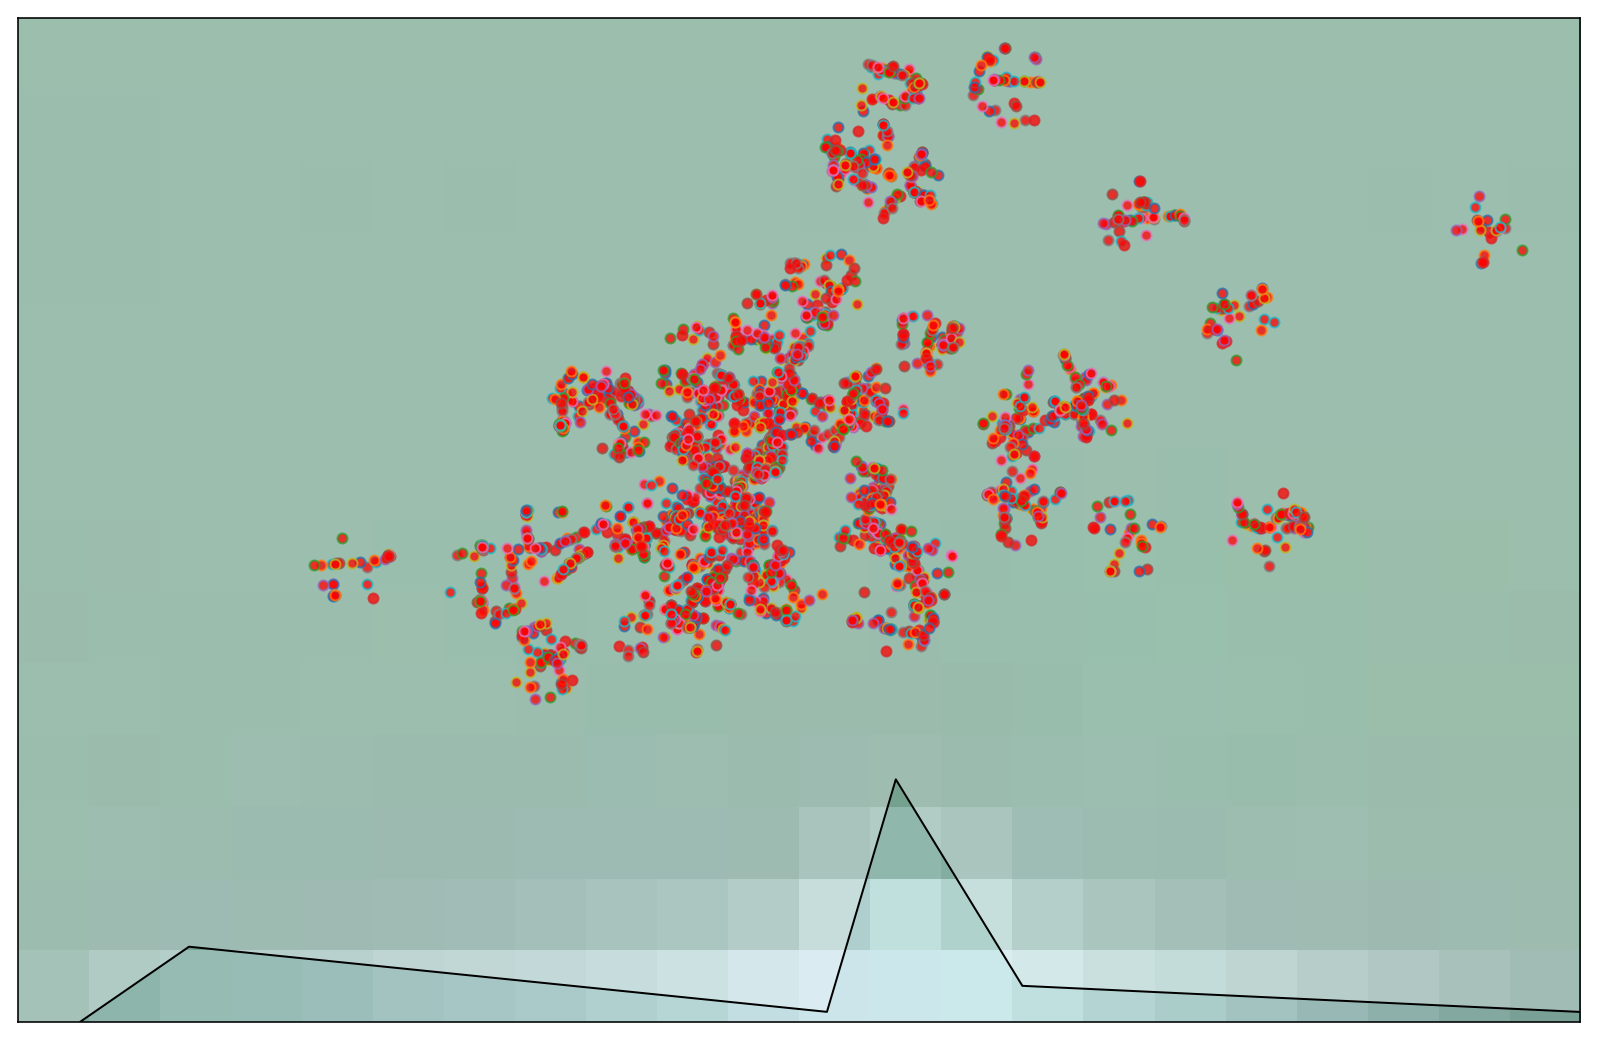

<Figure size 1008x1152 with 0 Axes>

In [80]:
rcParams['figure.figsize'] = (14,16)
my_map = Basemap(projection='merc',
            resolution = 'l', area_thresh = 1000.0, epsg = 4326,
            llcrnrlon = 100.20, llcrnrlat = 13.50, #min longitude (llcrnrlon) and latitude (llcrnrlat)
            urcrnrlon = 100.90, urcrnrlat = 13.95) #max longitude (urcrnrlon) and latitude (urcrnrlat)
 

my_map.drawcoastlines()
my_map.drawcountries()

my_map.fillcontinents(color = 'white', alpha = 0.3)
my_map.shadedrelief()

# To collect data based on stations      
xs,ys = my_map(np.asarray(dist_venues['Venue Longitude']), np.asarray(dist_venues['Venue Latitude']))
dist_venues['xm']= xs.tolist()
dist_venues['ym'] =ys.tolist()

#Visualization1
for index, row in dist_venues.iterrows():

    my_map.plot(row.xm, row.ym, markerfacecolor =([1,0,0]),  marker='o', markersize= 5, alpha = 0.75)

plt.show()

## Visualizing DBSCAN Clustering

The result of the using DBSCAN Clustering

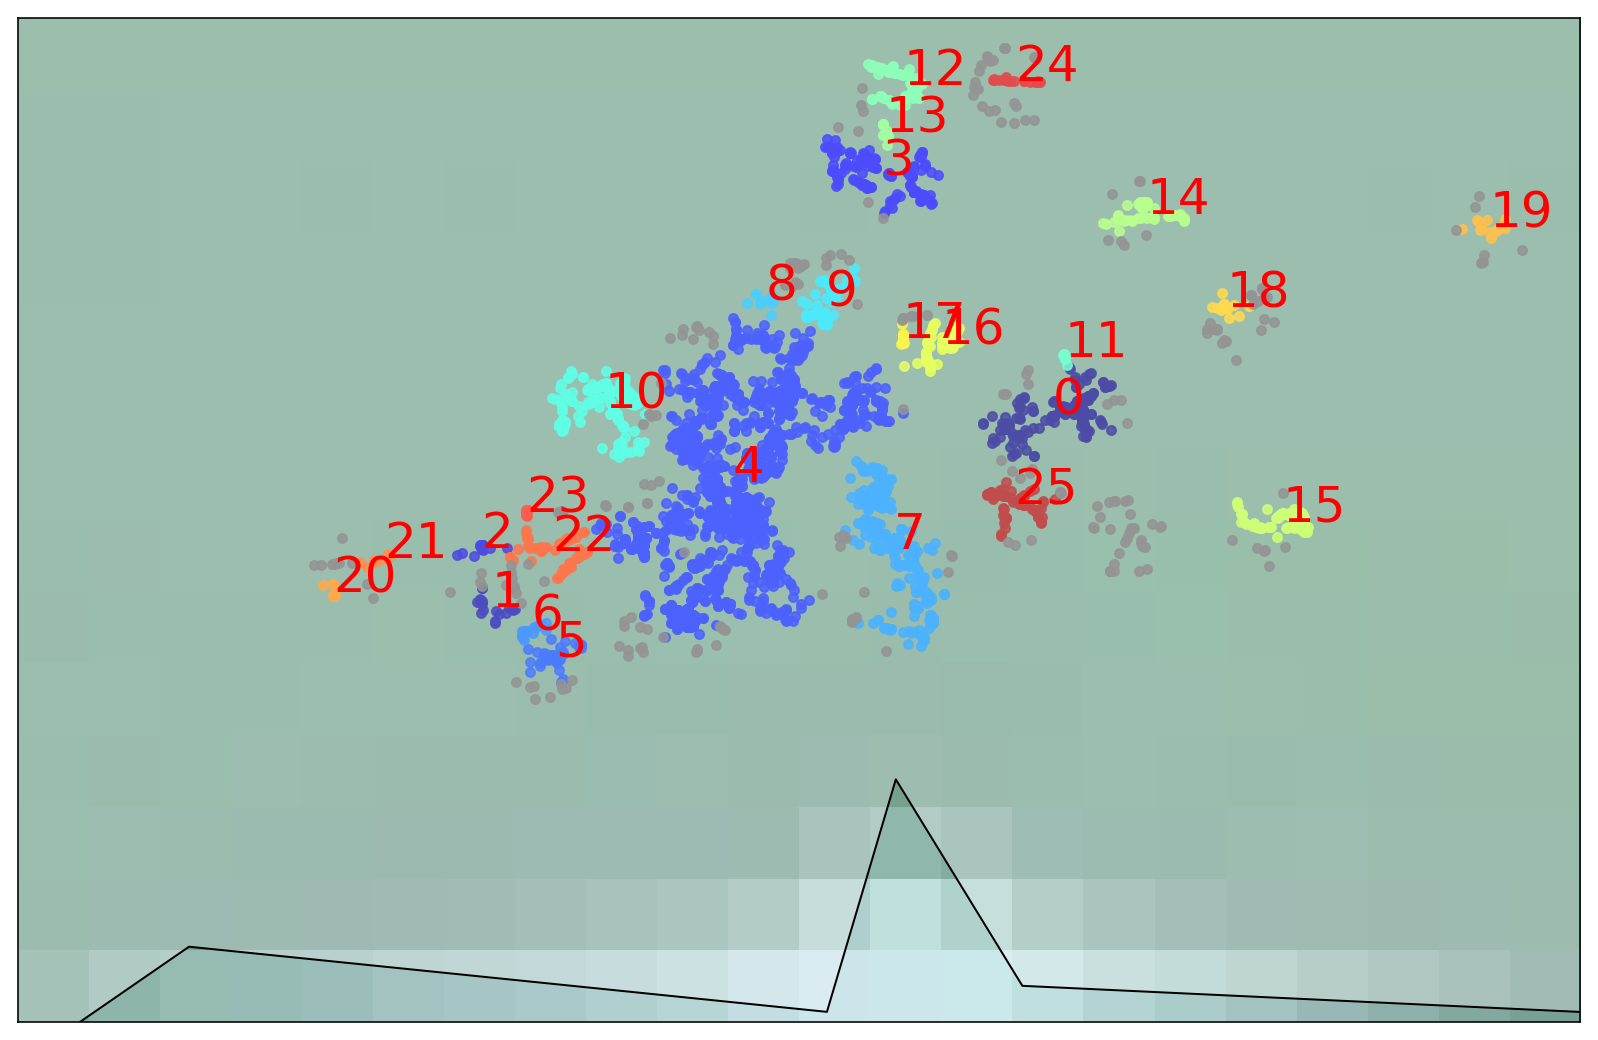

In [81]:
rcParams['figure.figsize'] = (14,16)

my_map = Basemap(projection='merc',
            resolution = 'l', area_thresh = 1000.0, epsg = 4326,
            llcrnrlon = 100.20, llcrnrlat = 13.50, #min longitude (llcrnrlon) and latitude (llcrnrlat)
            urcrnrlon = 100.90, urcrnrlat = 13.95) #max longitude (urcrnrlon) and latitude (urcrnrlat)


my_map.drawcoastlines()
my_map.drawcountries()
#my_map.drawmapboundary()
my_map.fillcontinents(color = 'white', alpha = 0.3)
my_map.shadedrelief()

# To create a color map
colors = plt.get_cmap('jet')(np.linspace(0.0, 1.0, clusterNum))



#Visualization1
for clust_number in set(labels):
    c=(([0.4,0.4,0.4]) if clust_number == -1 else colors[np.int(clust_number)])
    clust_set = dist_venues[dist_venues.Clus_Db == clust_number]                    
    my_map.scatter(clust_set.xm, clust_set.ym, color =c,  marker='o', s= 20, alpha = 0.85)
    if clust_number != -1:
        cenx=np.mean(clust_set.xm) 
        ceny=np.mean(clust_set.ym) 
        plt.text(cenx,ceny,str(clust_number), fontsize=25, color='red',)
        #print ("Cluster "+str(clust_number))

## Top 5 cluster

In [82]:
exclude_outlier = dist_venues[dist_venues['Clus_Db'] != -1]
top_clus=exclude_outlier.groupby(['Clus_Db']).count().sort_values(['Venue Category'], ascending=False).head()[['Venue']]
top_clus

,Venue
Clus_Db,
4,1885
7,370
0,280
10,196
3,163


## Visualization of the condo density and the top 5 DBSCAN clustering

In [83]:
map_dens = folium.Map(location=[latitude, longitude], zoom_start=10)

# Set colors
colors_clustop = {top_clus.index[0]:'#191970',
                  top_clus.index[1]:'#54aee5',
                  top_clus.index[2]:'#c70e0f',
                  top_clus.index[3]:'#cca304',
                  top_clus.index[4]:'#7a6e49'}
# Create Choropleth
folium.Choropleth(
    geo_data='geo_district.geojson',
    data=geojson_district,
    columns=['District', 'Venue Category'],
    key_on='feature.properties.dname_e',    
    fill_color='YlOrBr',
    fill_opacity=0.8,
    line_opacity=0.2,
    highlight=True,
    nan_fill_color='#8c8c8c',
    nan_fill_opacity=0.1,
    line_weight=0.7,
    name='The Condo of Bangkok (Choropleth)',
    legend_name='Condominium density of Bangkok').add_to(map_dens)

# Create Tooltips
folium.GeoJson(geojson_district[['geometry', 'District', 'Venue Category']],
                         name="The Condo of Bangkok (Area)",
                         style_function=lambda x: {'color':'gray','fillColor':'transparent','weight':1},
                         highlight_function=lambda x: {'weight':2,'fillColor':'gray'},
                         tooltip=folium.features.GeoJsonTooltip(fields=['District','Venue Category'],
                                                                aliases=['State:', 'Density:'], 
                                                                labels=True, 
                                                                sticky=True,
                                                                localize=True)).add_to(map_dens)

# Create cluster points
for lat, lng, dist, clus in zip(exclude_outlier['Venue Latitude'], 
                                exclude_outlier['Venue Longitude'],
                                exclude_outlier['Venue Category'],
                                exclude_outlier['Clus_Db']):
    
    if clus in colors_clustop:
        label = dist
        label = folium.Popup(label, parse_html=True)
        folium.CircleMarker([lat, lng],
                            radius=2,
                            popup=label,
                            color=colors_clustop[clus],
                            fill=True,
                            fill_color=colors_clustop[clus],
                            fill_opacity=0.7,
                            parse_html=False).add_to(map_dens)
        
# Create routes 
folium.GeoJson(geo_routes,
               name='Transportation Networks',
               style_function=lambda x: {'weight':2,'color':'#5369F4','dashArray':'1 0'},
               highlight_function=lambda x: {'weight':5,'color':'yellow', 'dashArray':'1 0'},
               tooltip=folium.features.GeoJsonTooltip(fields=['Name'],
                                                      labels=False)).add_to(map_dens)

#map_dens

folium.LayerControl(autoZIndex=True, collapsed=False).add_to(map_dens)

map_dens.save('map_clus.html')

![title](https://github.com/Supanut-k/The_Neighborhood_Of_The_Condo/blob/master/Maps/Map%20Images/map_clus.png?raw=true)

Interactive map [Click here](https://github.com/Supanut-k/The_Neighborhood_Of_The_Condo/blob/master/Maps/map_clus.html)

## Explore the venue of the DBSCAN clustering

Consider the top 5 clusters have a high density of venues

In [84]:
num_venue_clus = exclude_outlier.groupby(['Clus_Db'])['Venue Category'].count().reset_index()
num_venue_clus = num_venue_clus.sort_values(by='Venue Category', ascending=False).head().reset_index(drop=True)

# groupby Clus_Db coloumn
grouped_clus = pd.merge(exclude_outlier, num_venue_clus, how='inner', left_on='Clus_Db', right_on='Clus_Db' )
grouped_clus = grouped_clus.groupby(['Clus_Db', 'Venue Category_y', 'Venue Category_x']).count()[['Venue']]

grouped_clus = grouped_clus.sort_values(by=['Venue Category_y','Venue'], ascending=False)

grouped_clus

Venue
Clus_Db Venue Category_y Venue Category_x                               
4       1885             Noodle House                                181
                         Thai Restaurant                             176
                         Coffee Shop                                 125
                         Hotel                                        88
                         Chinese Restaurant                           72
                         Café                                         66
                         Convenience Store                            56
                         Asian Restaurant                             54
                         Bar                                          47
                         Dessert Shop                                 47
                         Som Tum Restaurant                           41
                         Seafood Restaurant                           39
                         Japanese Restaurant                          35
                         BBQ Joint                                    29
                         Hotpot Restaurant                            29
                         Hostel                                       26
                         Steakhouse                                   26
                         Restaurant                                   25
                         Spa                                          25
                         Ice Cream Shop                               24
                         Shopping Mall                                23
                         Bakery                                       22
                         Massage Studio                               20
                         Pub                                          18
                         Hotel Bar                                    16
                         Park                                         15
                         Cocktail Bar                                 14
                         Supermarket                                  14
                         Breakfast Spot                               13
                         Sushi Restaurant                             13
                         Train Station                                13
                         Art Gallery                                  12
                         Clothing Store                               11
                         Fast Food Restaurant                         11
                         Gym / Fitness Center                         11
                         Museum                                       11
                         Vietnamese Restaurant                        11
                         Burger Joint                                 10
                         Palace                                       10
                         Vegetarian / Vegan Restaurant                10
                         Bistro                                        9
                         Flea Market                                   9
                         Food Court                                    9
                         Italian Restaurant                            9
                         Korean Restaurant                             9
                         Market                                        9
                         Badminton Court                               8
                         Department Store                              8
                         Farmers Market                                8
                         Fried Chicken Joint                           8
                         Shabu-Shabu Restaurant                        8
                         Tea Room                                      8
                         Dim Sum Restaurant                            7
                         Halal Restaurant           

[View full dataset](https://github.com/Supanut-k/The_Neighborhood_Of_The_Condo/blob/master/Data/Top%205%20cluster%20density.csv)

## Top 10 venues of the DBSCAN clustering

Each cluster has a variety of venues.

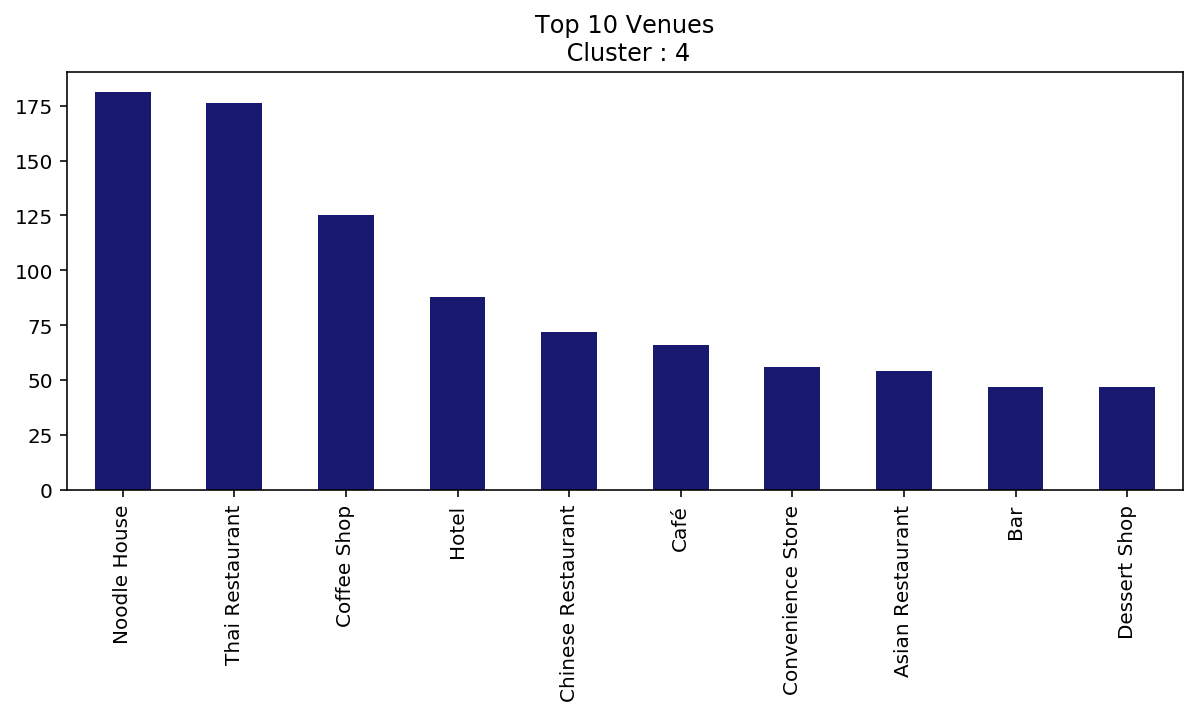

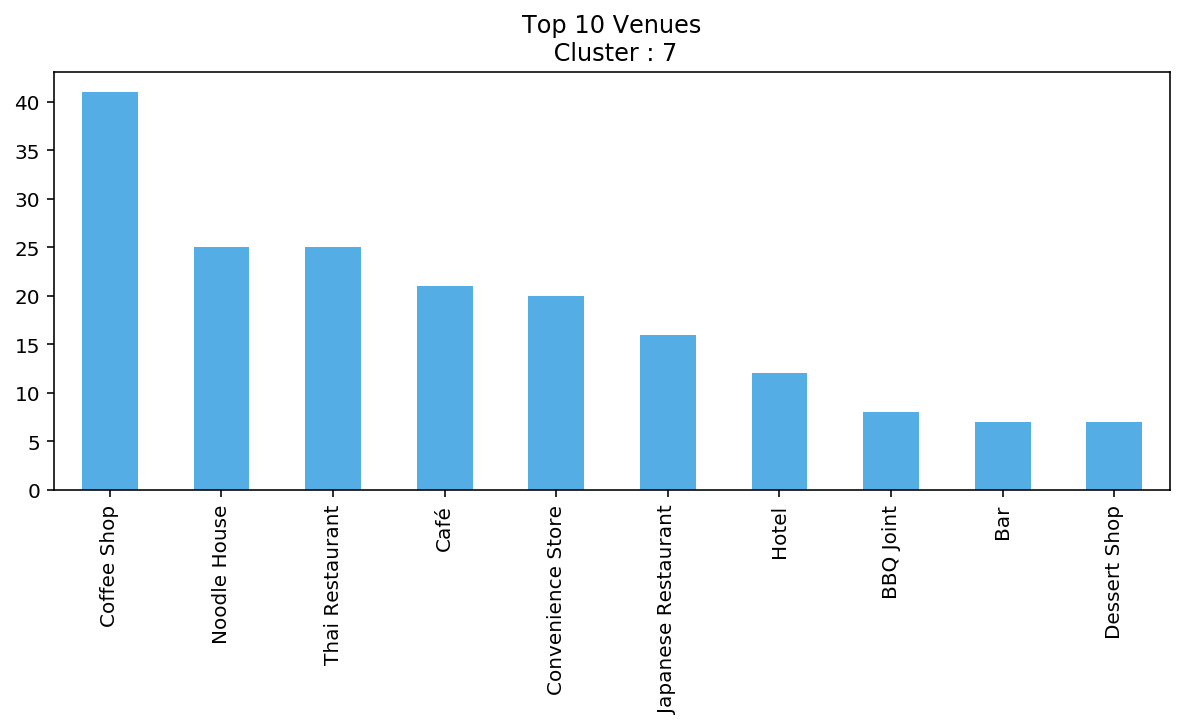

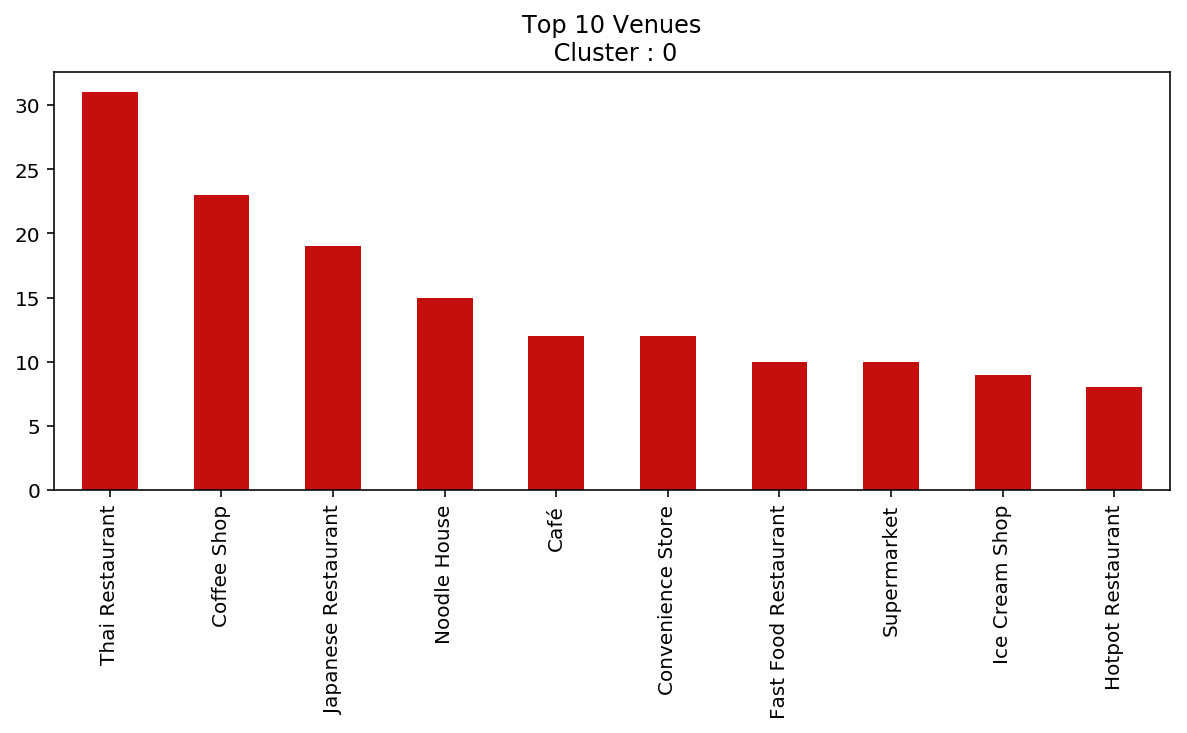

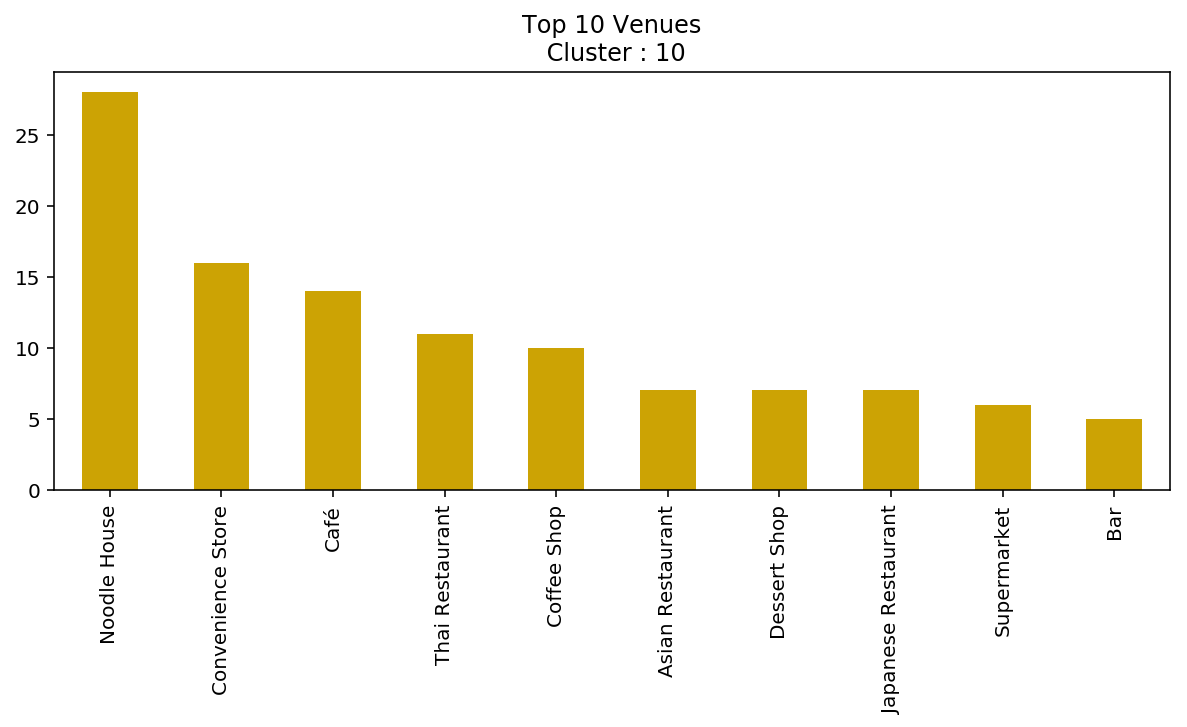

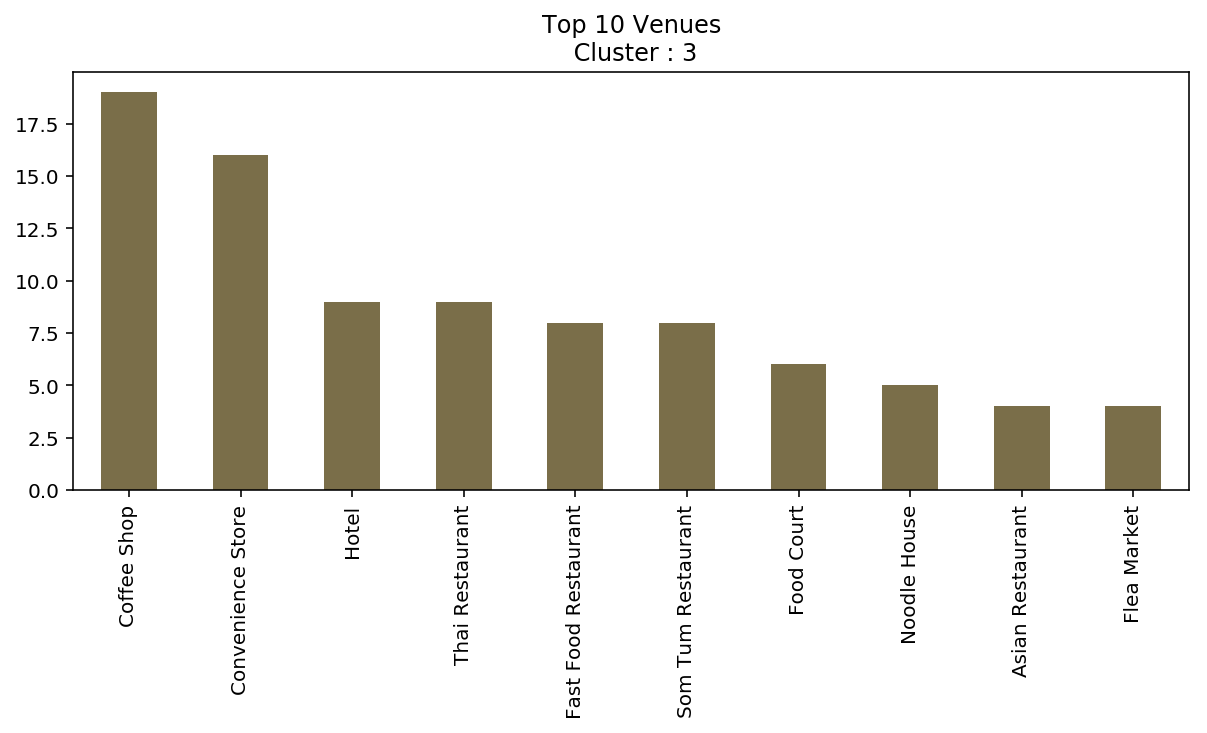

In [94]:
grouped_clus_bar = grouped_clus.reset_index()

for i in grouped_clus_bar['Clus_Db'].unique():
    bar_clus = grouped_clus_bar[grouped_clus_bar['Clus_Db'] == i][0:10]
    bar_clus.plot(kind='bar', x='Venue Category_x', y='Venue',                  
                  legend=False,
                  figsize=(10, 5),
                  color=colors_clustop[i])
    
    plt.subplots_adjust(bottom=0.3)
    plt.title('Top 10 Venues\n Cluster : {}'.format(i))    
    plt.xlabel('')
    plt.xticks(rotation=90)
    plt.savefig('Cluster_{}.png'.format(i))
